In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [2]:
files_gamma = os.listdir("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/gammas/numpy_v1/")
files_ele = os.listdir("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v1/")

In [3]:
print(f"N gamma files: {len(files_gamma)}")
print(f"N ele files: {len(files_ele)}")

N gamma files: 92
N ele files: 46


In [4]:
datas = []

for i in range(1, 35):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v1/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    outsc = d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == False)]
    insc =  d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == True)]    
    outsc = outsc.iloc[:len(insc)*5]
    datas += [insc, outsc]
    
data_ele = pd.concat(datas, ignore_index=True)
data_ele["particle"] = "electron"

datas = []

for i in range(1, 70):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/gammas/numpy_v1/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    outsc = d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == False)]
    insc =  d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == True)]    
    outsc = outsc.iloc[:len(insc)*5]
    datas += [insc, outsc]
    
data_gamma = pd.concat(datas, ignore_index=True)
data_gamma["particle"] = "gamma"

Balance gamma and electron

In [5]:
data = pd.concat([data_gamma.iloc[:len(data_ele)], data_ele], ignore_index=True)

In [6]:
insc = data[data.in_scluster]
outsc = data[(data.in_scluster == False)]

In [7]:
print("N in supercluster: ", len(insc))
print("N out supercluster: ", len(outsc))

N in supercluster:  877619
N out supercluster:  4385161


In [8]:
print("electron:" , len(data_ele))
print("gamma: ", len(data_gamma))

electron: 2631390
gamma:  3361434


## Check plots

(array([[1.265091  , 0.93388692, 1.1999361 , ..., 0.92845734, 1.04247842,
         0.96917916],
        [1.21622483, 1.21079525, 1.05605236, ..., 0.82258063, 0.9827531 ,
         0.96103479],
        [1.08862981, 1.04519321, 1.08862981, ..., 0.86873202, 0.98546788,
         0.99089746],
        ...,
        [1.0913446 , 1.05333757, 1.12663684, ..., 0.93117213, 1.15106992,
         1.02347491],
        [1.31395718, 1.05876715, 1.16192907, ..., 0.84972851, 0.99904182,
         1.01804533],
        [1.18636216, 1.08862981, 1.21893961, ..., 0.93117213, 1.14021077,
         0.91759819]]),
 array([-6.99999958e-01, -6.85999963e-01, -6.71999968e-01, -6.57999972e-01,
        -6.43999977e-01, -6.29999982e-01, -6.15999987e-01, -6.01999991e-01,
        -5.87999996e-01, -5.74000001e-01, -5.60000005e-01, -5.46000010e-01,
        -5.32000015e-01, -5.18000019e-01, -5.04000024e-01, -4.90000029e-01,
        -4.76000034e-01, -4.62000038e-01, -4.48000043e-01, -4.34000048e-01,
        -4.20000052e-01, -4.0

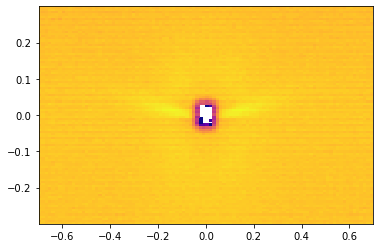

In [9]:
plt.hist2d(outsc.cluster_dphi, outsc.cluster_deta, 
           density=True, bins=(100,100),cmap="plasma", norm=colors.LogNorm())

## Weights by DeltaPhi

In [10]:
cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]

In [11]:
X = data[ cols ].values
truth = data[["in_scluster", "nclusters"]].values
y = np.array(truth[:,0], dtype=int)
#train_weights = data.train_weight.values

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open("../models/scaler_model13.pkl", "wb"))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.17)

In [11]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

In [12]:
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
training_generator, steps_per_epoch_train = balanced_batch_generator(X_train, y_train,  batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val = balanced_batch_generator(X_val, y_val, batch_size=1024, sampler=RandomOverSampler())

Using TensorFlow backend.


# Training

In [13]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

In [22]:
model = Sequential()
model.add(Dense(100, input_dim=7, activation="relu"))
model.add(Dropout(0.3))
#model.add(Dense(80, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 100)               800       
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 5,901
Trainable params: 5,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=5)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=10, verbose=1)

history = model.fit_generator(
            training_generator, 
            epochs=100,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks = [early_stop]
            )

Epoch 1/100
7108/7108 [==============================] - 37s 5ms/step - loss: 0.1253 - acc: 0.9523 - val_loss: 0.0938 - val_acc: 0.9641
Epoch 2/100
7108/7108 [==============================] - 35s 5ms/step - loss: 0.1040 - acc: 0.9608 - val_loss: 0.0904 - val_acc: 0.9653
Epoch 3/100
7108/7108 [==============================] - 32s 5ms/step - loss: 0.1013 - acc: 0.9619 - val_loss: 0.0892 - val_acc: 0.9655
Epoch 4/100
7108/7108 [==============================] - 32s 5ms/step - loss: 0.1000 - acc: 0.9625 - val_loss: 0.0883 - val_acc: 0.9662
Epoch 5/100
7108/7108 [==============================] - 31s 4ms/step - loss: 0.0994 - acc: 0.9626 - val_loss: 0.0883 - val_acc: 0.9663
Epoch 6/100
7108/7108 [==============================] - 31s 4ms/step - loss: 0.0990 - acc: 0.9627 - val_loss: 0.0881 - val_acc: 0.9663
Epoch 7/100
7108/7108 [==============================] - 31s 4ms/step - loss: 0.0986 - acc: 0.9629 - val_loss: 0.0876 - val_acc: 0.9664
Epoch 8/100
7108/7108 [=========================

In [24]:
model.save("../models/model12_balanced_100_50.hd5")

In [ ]:
history = model.fit(
            x = X_train, y = y_train, 
            epochs=200,
            batch_size = 1024, 
            shuffle=True, 
            validation_split=0.15, 
            callbacks = [auto_save, early_stop]
            )

>>> Computing AUC...
AUC score: 0.99532438640397
>>> Saving ROC curve...


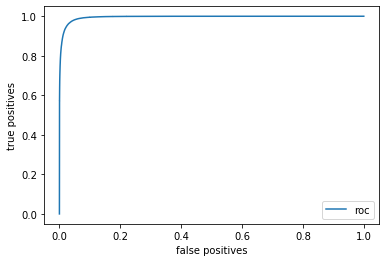

In [25]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test,batch_size=2048)
auc = roc_auc_score(y_test, pred)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_test, pred)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)
plt.legend()

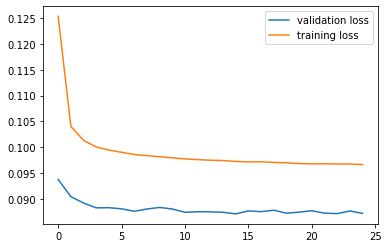

In [29]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

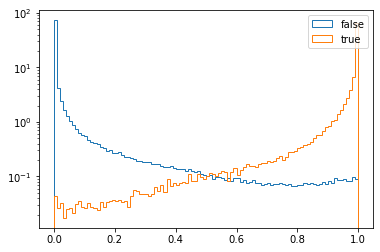

In [28]:
results = model.predict(X_test)
plt.hist(results[y_test==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_test==1], bins=100, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [108]:
datas_val = []

for i in range(80, 127):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/numpy_v3/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    datas_val.append(d[(d.is_calo) & (d.is_seed == False)])
        
data_val  = pd.concat(datas_val, ignore_index=True)

cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster"]

In [26]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve
y_test = np.array(data_val.in_scluster, dtype=int)
pred = data_val["y"].values
auc = roc_auc_score(y_test,pred)
print("AUC score: " + str(auc))


>>> Computing AUC...


NameError: name 'data_val' is not defined

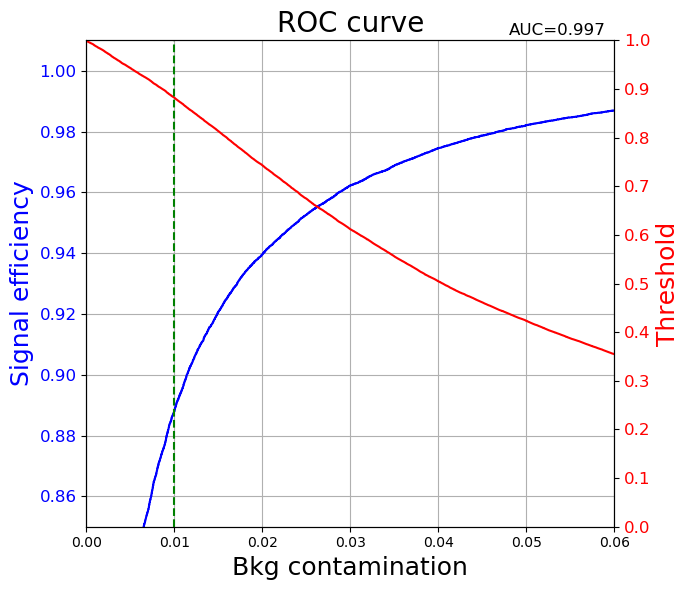

In [27]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

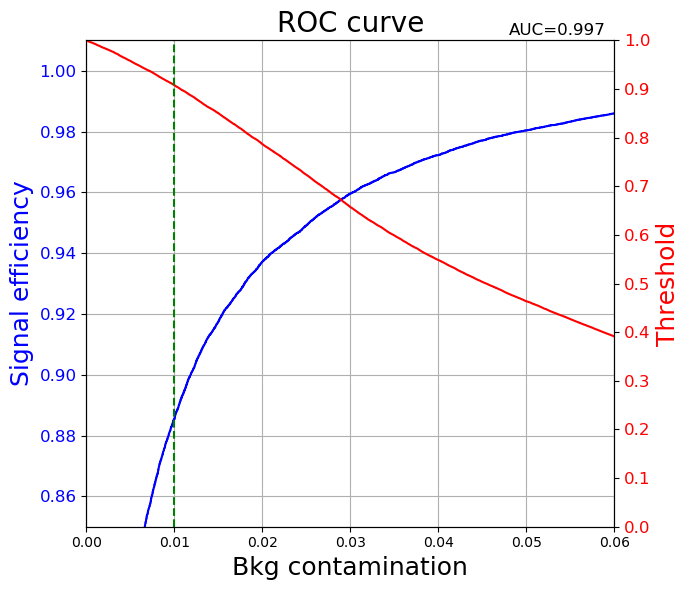

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

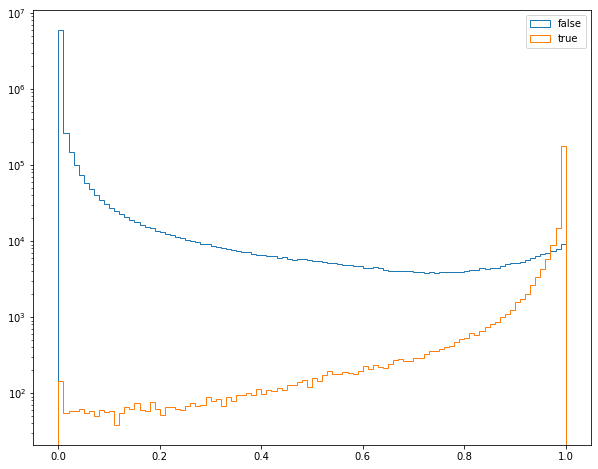

In [34]:
plt.hist(data_out["y"], bins=100, label="false", histtype="step")
plt.hist(data_in["y"], bins=100, label="true", histtype="step")
plt.yscale("log")
plt.legend()

(-0.6, 0.6)

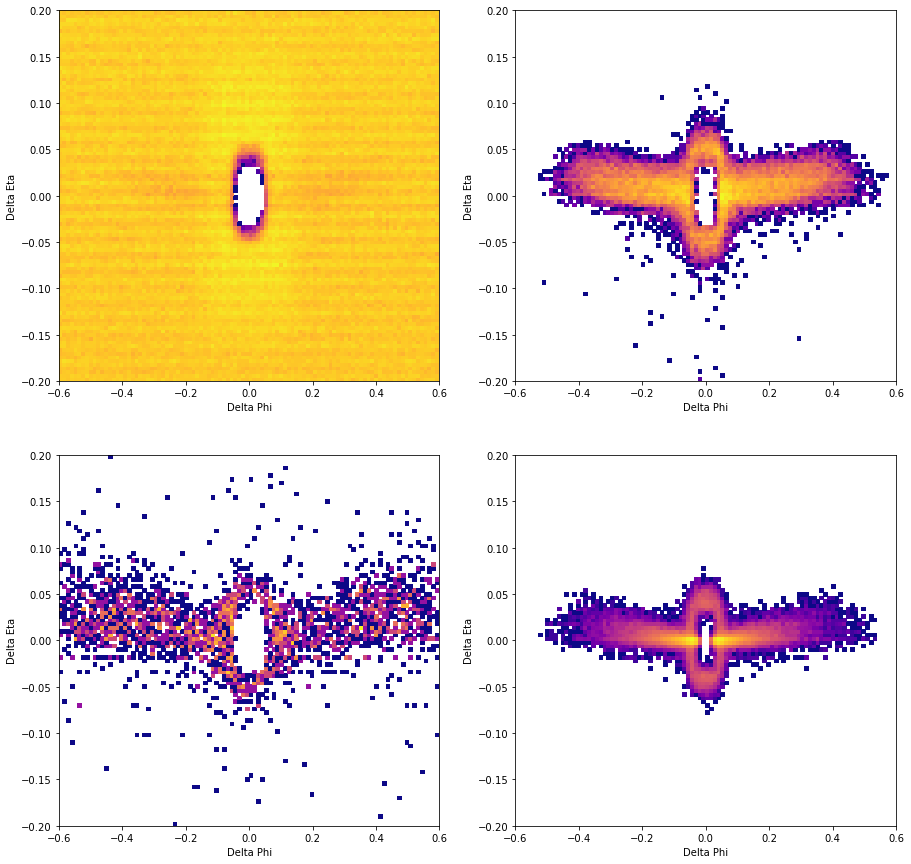

In [48]:
tr = 0.8
data_out_0 = data_out[data_out.y < tr]
data_out_1 = data_out[data_out.y > tr]
data_in_0 = data_in[data_in.y < tr]
data_in_1 = data_in[data_in.y > tr]

eta_min = 0
eta_max = 1
nbins = 100
fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0][0].hist2d(data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_0[ (abs(data_out_0.seed_eta)> eta_min) & (abs(data_out_0.seed_eta)< eta_max) ].cluster_deta,
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][1].hist2d(data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_out_1[ (abs(data_out_1.seed_eta)> eta_min) & (abs(data_out_1.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][0].hist2d(data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_0[ (abs(data_in_0.seed_eta)> eta_min) & (abs(data_in_0.seed_eta)< eta_max) ].cluster_deta,  
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[1][1].hist2d(data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_dphi, 
                data_in_1[ (abs(data_in_1.seed_eta)> eta_min) & (abs(data_in_1.seed_eta)< eta_max) ].cluster_deta,   
                density=True, bins=(nbins,nbins), range=((-0.6,0.6),(-0.2,0.2)), cmap="plasma", norm=colors.LogNorm())
ax[0][0].set_ylabel("Delta Eta")
ax[0][0].set_xlabel("Delta Phi")
ax[1][0].set_ylabel("Delta Eta")
ax[1][0].set_xlabel("Delta Phi")
ax[0][1].set_ylabel("Delta Eta")
ax[0][1].set_xlabel("Delta Phi")
ax[1][1].set_ylabel("Delta Eta")
ax[1][1].set_xlabel("Delta Phi")

ax[1][0].set_ylim(-0.2, 0.2)
ax[1][0].set_xlim(-0.6,0.6)
ax[0][0].set_ylim(-0.2, 0.2)
ax[0][0].set_xlim(-0.6,0.6)
ax[1][1].set_ylim(-0.2, 0.2)
ax[1][1].set_xlim(-0.6,0.6)
ax[0][1].set_ylim(-0.2, 0.2)
ax[0][1].set_xlim(-0.6,0.6)